In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from pathlib import Path
import os

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
data_dir = Path('/gdrive/MyDrive/berlin_bike_CV/final_project_first_images')

In [ ]:
# auxiliary visualization function

def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

In [ ]:
batch_size = 48
test_batch_size = 48
epochs = 20
# lr = 0.003
# lr = 0.001
lr = 0.0003
seed = 42
image_height = 256
image_width = 256

# unfreeze all parameters after x epochs
unfreeze = False
epochs_freeze = 5

In [ ]:
# Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(10),
                                       transforms.Resize((image_height, image_width)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize((image_height, image_width)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

# Create dataset
train_data_old = datasets.ImageFolder(data_dir / 'train', transform=train_transforms)
test_data_old = datasets.ImageFolder(data_dir / 'test', transform=test_transforms)

In [ ]:
# Remapped Dataset with defined classes
class RemappedDataset(torch.utils.data.Dataset):
    def __init__(self, original_dataset, class_mapping):
        self.original_dataset = original_dataset
        self.class_mapping = class_mapping

    def __getitem__(self, index):
        image, label = self.original_dataset[index]
        new_label = self.class_mapping[self.original_dataset.classes[label]]
        return image, new_label

    def __len__(self):
        return len(self.original_dataset)

    @property
    def classes(self):
        return list(self.class_mapping.keys())

# classes
class_mapping = {'road': 0, 'cobblestones': 1}

train_data = RemappedDataset(train_data_old, class_mapping)
test_data = RemappedDataset(test_data_old, class_mapping)

In [ ]:
# define dataloader
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=test_batch_size)

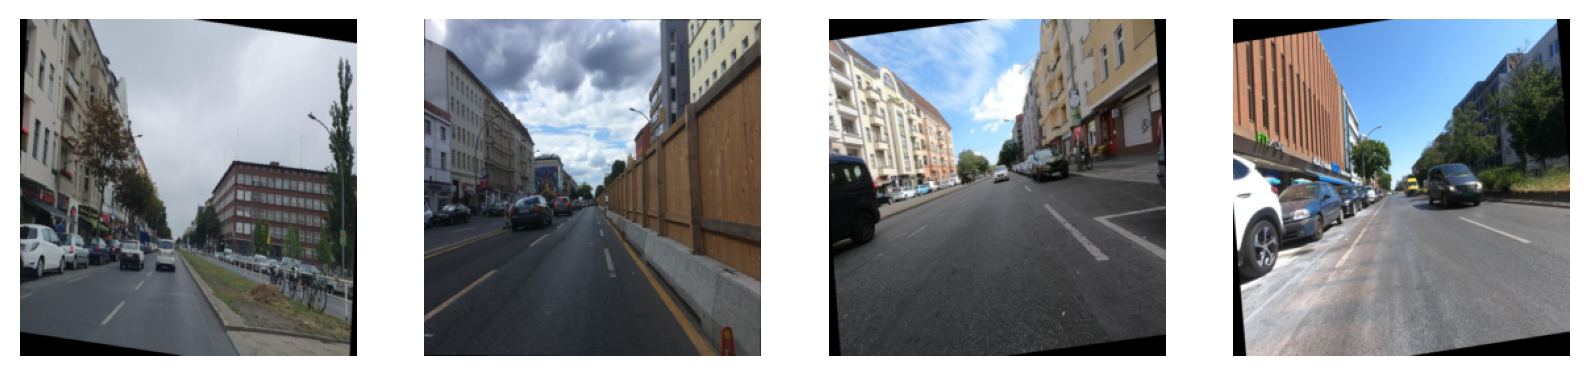

In [ ]:
# test data loader
data_iter = iter(trainloader)

images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    imshow(images[ii], ax=ax, normalize=True)

In [ ]:
# choose model
model = models.efficientnet_v2_s(weights='IMAGENET1K_V1')

# model

In [ ]:
model.classifier[1]

Linear(in_features=1280, out_features=1000, bias=True)

In [ ]:
# Unfreeze parameters
for param in model.parameters():
    param.requires_grad = True

# adapt output layer
from collections import OrderedDict
fc = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(1280, 2)),
    ('output', nn.Softmax(dim=1))
    ]))

model.classifier[1] = fc

In [ ]:
# model

In [ ]:
# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = nn.CrossEntropyLoss()

# Start with training the output layer parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier[1].parameters(), lr=lr)

model.to(device);

In [ ]:
torch.manual_seed(seed)

train_loss_list = []
test_loss_list = []
accuracy_list = []
for epoch in range(epochs):
    running_loss = 0
    test_loss = 0
    accuracy = 0
    example_images = []

    for inputs, labels in trainloader:
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)

        # unfreeze and optimize all parameters after x epochs
        if unfreeze and epoch >= epochs_freeze:
            optimizer = optim.Adam(model.parameters(), lr=lr)

        optimizer.zero_grad()

        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        # for i, l in enumerate(logps):
        #   print(f"Train: True Label: {labels[i]}, prediction: {l}")


    with torch.no_grad():
        model.eval()
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            logps = model.forward(inputs)
            batch_loss = criterion(logps, labels)

            test_loss += batch_loss.item()

            binary_predictions = torch.argmax(logps, dim=1)

            equals = binary_predictions == labels
            acc =  torch.mean(equals.type(torch.FloatTensor)).item()
            accuracy += acc
            # for i, l in enumerate(logps):
            #   print(f"Test:  True Label: {labels[i]}, prediction: {l}")

    model.train()

    train_loss_list.append(running_loss/len(trainloader))
    test_loss_list.append(test_loss/len(testloader))
    accuracy_list.append(accuracy/len(testloader))


    print(f"Epoch {epoch+1}/{epochs}.. ",
          f"Train loss: {train_loss_list[-1]:.3f}.. ",
          f"Test loss: {test_loss_list[-1]:.3f}.. ",
          f"Test accuracy: {accuracy_list[-1]:.3f}",)

print("Done.")

In [ ]:
# save model
torch.save(model, "/gdrive/MyDrive/private_berlin_bike/EfficientNet_CELoss.pt")

In [ ]:
# evaluate model
test_label = []
test_prob = []

with torch.no_grad():
    model.eval()
    for inputs, labels in testloader:
        inputs = inputs.to(device)
        # probabilities of the positive class
        logps = model.forward(inputs)[:, 1].tolist()
        labels = labels.tolist()
        test_label.extend(labels)
        test_prob.extend(logps)


In [ ]:
# plot precision-recall curve
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, f1_score
import numpy as np

# calculate Precision, Recall and Threshold
precision, recall, thresholds = precision_recall_curve(test_label, test_prob)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
# plot the precision-recall curve for the model
no_skill = np.mean(test_label)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='classifier')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

In [ ]:
def to_labels(pos_probs, threshold):
 return (pos_probs >= threshold).astype('int')

test_pred = to_labels(test_prob, thresholds[ix])

precision = precision_score(test_label, test_pred)
recall = recall_score(test_label, test_pred)
f1 = f1_score(test_label, test_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

In [ ]:
# plot performance
def plot_training(train_loss_list, test_loss_list, accuracy_list):
  plt.plot(train_loss_list,label='training loss')
  plt.plot(test_loss_list,label='testing loss')
  plt.legend()
  plt.show()
  plt.plot(accuracy_list,label='accuracy')
  plt.legend()
  plt.show()

plot_training(train_loss_list, test_loss_list, accuracy_list)